In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive

Mounted at /gdrive
/gdrive/MyDrive


In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras  
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TimeDistributed, LayerNormalization, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Conv2D, GlobalMaxPooling2D, LSTM, Permute, Reshape
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score

In [ ]:
X1 = np.load('X_warblrb.npy')
X2 = np.load('X_ff.npy')
#X3 =  np.load('X_extra_pos.npy')
X = np.concatenate((X1, X2), axis=0)

y1 = np.load('y_warblrb.npy')
y2 = np.load('y_ff.npy')
#y3 = np.load('y_extra_pos.npy')
y = np.concatenate((y1, y2), axis=0)

print('Shape X1: ', X1.shape)
print('Shape X2: ', X2.shape)
print('Shape X3: ', X3.shape)
print('Shape X', X.shape)
print('Shape y1: ', y1.shape)
print('Shape y2: ', y2.shape)
print('Shape y3: ', y3.shape)
print('Shape y: ', y.shape)

Shape X1:  (3177, 40, 501)
Shape X2:  (7690, 40, 501)
Shape X3:  (578, 40, 501)
Shape X (11445, 40, 501)
Shape y1:  (3177,)
Shape y2:  (7690,)
Shape y3:  (578,)
Shape y:  (11445,)


(array([6506., 4939.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

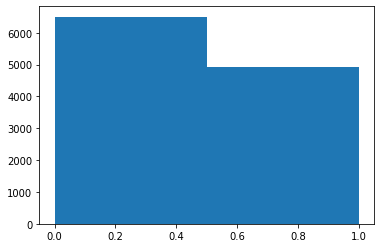

In [ ]:
plt.hist(y, bins=2)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=12)
for train_ind, val_ind in sss.split(X, y):
    print("TRAIN:", train_ind, "VAL:", val_ind)
    X_train, X_val = X[train_ind], X[val_ind]
    y_train, y_val = y[train_ind], y[val_ind]

print(X_train.shape, X_val.shape)

TRAIN: [ 3441 11340   785 ...  7675 10161 10156] VAL: [11359 10222  7213 ...  4960  7391  3473]
TRAIN: [ 9555  2668  1173 ... 11441  8537  3755] VAL: [6999 3590 5822 ... 3037 3360 7430]
TRAIN: [7006 9260   94 ... 9521 6396 4084] VAL: [5508 3482 8104 ... 2437 7973 7950]
TRAIN: [5361 1296 4354 ... 8040 1075 7601] VAL: [8796 4710 9432 ... 2073 8426 5419]
TRAIN: [6914 7176 4999 ...  285 8621 6578] VAL: [3480  200 4415 ... 3820 1139  819]
(9156, 40, 501) (2289, 40, 501)


# CNN


## 2D CNN


In [ ]:
# Scale data to range 0 to 1

scaler = MinMaxScaler()

scaled_X_train_flatten = scaler.fit_transform(X_train_flatten)
scaled_X_train_flatten = np.reshape(scaled_X_train_flatten, (len(X_train), 40, 501))

scaled_X_test_flatten = scaler.transform(X_test_flatten)
scaled_X_test_flatten = np.reshape(scaled_X_test_flatten, (len(X_test), 40, 501))

In [ ]:
conv2D = Sequential([Conv2D(filters=32,kernel_size=(3,3), activation='relu', padding='same', input_shape=(40, 501, 1)), 
                     MaxPooling2D(pool_size=(2,2), padding='same'), 
                     
                     Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'), 
                     MaxPooling2D(pool_size=(2,2), padding='same'), 
                     
                     Conv2D(128, kernel_size=(3,3), activation='relu', padding='same',activity_regularizer=l1(0.01)),
                     MaxPooling2D(pool_size=(2,2), padding='same'), 
                     
                     Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'), 
                     MaxPooling2D(pool_size=(2,2), padding='same'),

                     Dropout(0.2),
                     Flatten(),
                     Dense(16, activity_regularizer=l1(0)),
                     Dense(1, activation='sigmoid')])

conv2D.compile(optimizer='adam', loss='binary_crossentropy', metrics=[[tf.keras.metrics.AUC()]])
conv2D.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 40, 501, 32)       320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 20, 251, 32)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 20, 251, 64)       18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 10, 126, 64)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 10, 126, 128)      73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 5, 63, 128)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 5, 63, 256)      

## conv1D

In [ ]:
conv1D = Sequential([Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(40, 501, 1)),
                   MaxPooling2D(),
                   Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
                   MaxPooling2D(),
                   Flatten(),
                   Dense(15, activation='softmax')])

conv1D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[[tf.keras.metrics.AUC()]])
conv1D.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 40, 501, 32)       320       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 20, 250, 32)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 20, 250, 32)       9248      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 10, 125, 32)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 40000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 15)                600015    
Total params: 609,583
Trainable params: 609,583
Non-trainable params: 0
_______________________________________________

# RNN


In [ ]:
RNN = Sequential([LSTM(32, return_sequences=True, input_shape=(501, 40)),
                  LSTM(64, return_sequences=True),
                  Flatten(),
                  Dense(128),
                  Dense(1, activation='sigmoid')])

RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
RNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 501, 32)           9344      
_________________________________________________________________
lstm_4 (LSTM)                (None, 501, 64)           24832     
_________________________________________________________________
flatten_7 (Flatten)          (None, 32064)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                513040    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 547,233
Trainable params: 547,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Scale with mean 0 and standard deviation 1
standard_scaler = StandardScaler()

scaled_X_train_flatten = standard_scaler.fit_transform(X_train_flatten)
scaled_X_train_flatten = np.reshape(scaled_X_train_flatten, (len(X_train), 40, 501))

scaled_X_test_flatten = standard_scaler.transform(X_test_flatten)
scaled_X_test_flatten = np.reshape(scaled_X_test_flatten, (len(X_test), 40, 501))

RNN.fit(X_mix.swapaxes(1,2), y_train_onehot, validation_split=0.2, epochs=20)
test_loss, test_acc = RNN.evaluate(scaled_X_test_flatten.swapaxes(1,2), y_test_onehot)
print("Accuracy with RNN is", test_acc)

# CRNN


In [ ]:
CRNN = Sequential([Conv2D(filters=96, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(40, 501, 1)),
                   MaxPooling2D(pool_size=(5, 1), padding='same'), 

                   Conv2D(96, kernel_size=(5, 5), activation='relu', padding='same'), 
                   MaxPooling2D(pool_size=(2, 1), padding='same'),

                   Conv2D(96, kernel_size=(5, 5), activation='relu', padding='same'), 
                   MaxPooling2D(pool_size=(2, 1), padding='same'),
                   
                   Conv2D(96, kernel_size=(5, 5), activation='relu', padding='same'), 
                   MaxPooling2D(pool_size=(2, 1), padding='same'),

                   Reshape((501, 96)),
                   GRU(96, return_sequences=True),
                   GRU(96, return_sequences=True),

                   MaxPooling1D(pool_size=501, strides=1),
                   Flatten(),
                   # Dropout(0.25),
                   Dense(1, activation='sigmoid')])  # , activity_regularizer=l1(1e-3)

opt = Adam(learning_rate= 1e-3)
CRNN.compile(opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
CRNN.summary()

In [ ]:
# Scale data to range 0 to 1
scaler = MinMaxScaler()

scaled_X_train_flatten = scaler.fit_transform( np.reshape(X_train, (len(X_train), 40*501)) )
scaled_X_train = np.reshape(scaled_X_train_flatten, (len(X_train), 40, 501))

scaled_X_val_flatten = scaler.transform( np.reshape(X_val, (len(X_val), 40*501)) )
scaled_X_val = np.reshape(scaled_X_val_flatten, (len(X_val), 40, 501))

print(scaled_X_train.shape, scaled_X_val.shape)

(9156, 40, 501) (2289, 40, 501)


In [ ]:
# define the checkpoint
filepath = "CRNN_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history = CRNN.fit(np.expand_dims(scaled_X_train, -1), y_train, validation_data=(np.expand_dims(scaled_X_val, -1), y_val), batch_size=64, epochs=23)

- Highest val_auc is 0.948 after 23 epochs, training auc is 0.9658.
- Stop at 20-25 epochs might be a good idea, val_auc is around 0.94-0.95, auc is around 0.96-0.97.
- After 20-25 epochs, val_auc is fluctuating between 0.93 and 0.94, val_loss is fluctuating 0.30 and 0.37. Training auc is increasing monotically to 1 while training loss is decreasing to 0. => Overfitting
- After 45 epochs, val_loss even increase to around 0.4
- With dropout layer with rate 0.25 before the ouput layer, the auc and val_auc is 0.96 is around 0.965 to 0.940, loss and val_loss are 0.23 and 0.3-0.35.
- With about new 500 data from test file, same model without any regularizationn, the val_auc and auc after 23 epochs are 0.95 and 0.97, val_loss and loss are 0.23 and 0.21.
- After training for more than 30 epochs, the model starts to become overfitting again. One clear conclusion after trying to add more example is that it might not work since we may infer wrong labels to test data. One reason could also be the fact that we only add "positive" (prob > 0.999) test data to counter imbalance current dataset a bit more (Negative sample is more than positive 1500 samples), and this actually makes the model bias towards positive result.
- One things we should try instead is cutting longer audio, e.x 12-14s, but since this task is quite tedious, so we choose the easier way (inferring test data)
- Pre-emphasize training data help a lot since it didn't make the data change much in terms of acoustic, not only reduce noise of background. But since the test data has background noise as wind,... blending with birds, pre-emphasizing test data change the bird sounds' quality a lot. 


In [ ]:
plt.plot(history.history['auc'], label="auc")
plt.plot(history.history['val_auc'], label="val_auc")
plt.legend(loc="lower right")
plt.grid("on")
plt.show()

plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(loc="lower right")
plt.grid("on")
plt.show()

KeyError: ignored

# Save model

In [ ]:
# Serialize model to JSON
model_json = loaded_model.to_json()
with open("CRNN_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
loaded_model.save_weights("CRNN_weights.h5")
print("Saved model to disk")

Saved model to disk


# Load model

In [ ]:
# Scale data to range 0 to 1
scaler = MinMaxScaler()

scaled_X_train_flatten = scaler.fit_transform( np.reshape(X_train, (len(X_train), 40*501)) )
scaled_X_train = np.reshape(scaled_X_train_flatten, (len(X_train), 40, 501))

scaled_X_val_flatten = scaler.transform( np.reshape(X_val, (len(X_val), 40*501)) )
scaled_X_val = np.reshape(scaled_X_val_flatten, (len(X_val), 40, 501))

print(scaled_X_train.shape, scaled_X_val.shape)

(9156, 40, 501) (2289, 40, 501)


In [ ]:
from keras.models import model_from_json

# Load json and create model
json_file = open('CRNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("CRNN_weights.h5")

#loaded_model.get_layer('dense_1').kernel_regularizer = l1(0.001) 
loaded_model.layers[-1].activity_regularizer = l1(0.001)

opt = Adam(learning_rate= 1e-3)
loaded_model.compile(opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
loaded_model.summary()
print("Loaded model from disk")

history = loaded_model.fit(np.expand_dims(scaled_X_train, -1), y_train, validation_data=(np.expand_dims(scaled_X_val, -1), y_val), batch_size=64, epochs=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 40, 501, 96)       2496      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 501, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 501, 96)        230496    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 501, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 501, 96)        230496    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 501, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 501, 96)        2

# Evaluate loaded model on test data

In [ ]:
# Getting more RAM :))
a = []
while(1):
    a.append('1')

In [ ]:
X_test = np.load('X_test_emphasized.npy')
print('Shape X_test: ', X_test.shape)

scaled_X_test_flatten = scaler.transform( np.reshape(X_test, (len(X_test), 40*501)) )
scaled_X_test = np.reshape(scaled_X_test_flatten, (len(X_test), 40, 501))
print(scaled_X_test.shape)

y_pred = loaded_model.predict(np.expand_dims(scaled_X_test, -1))
np.save("prediction.npy", y_pred)

with open("colab_crnn_submission.csv", "w") as fp: 
    fp.write("Id,Predicted\n") 
    for idx in range(4512): 
        fp.write(f"{idx},{y_pred[idx][0]}\n") 

Shape X_test:  (4512, 40, 501)
(4512, 40, 501)


In [ ]:
X_test_raw = np.load('X_test_raw.npy')
print('Shape X_test: ', X_test_raw.shape)

scaled_X_test_raw_flatten = scaler.transform( np.reshape(X_test_raw, (len(X_test_raw), 40*501)) )
scaled_X_test_raw = np.reshape(scaled_X_test_raw_flatten, (len(X_test_raw), 40, 501))
print(scaled_X_test_raw.shape)

y_pred_raw = loaded_model.predict(np.expand_dims(scaled_X_test_raw, -1))
np.save("prediction_raw.npy", y_pred_raw)

with open("colab_crnn_submission_raw.csv", "w") as fp: 
    fp.write("Id,Predicted\n") 
    for idx in range(4512): 
        fp.write(f"{idx},{y_pred_raw[idx][0]}\n") 

Shape X_test:  (4512, 40, 501)
(4512, 40, 501)


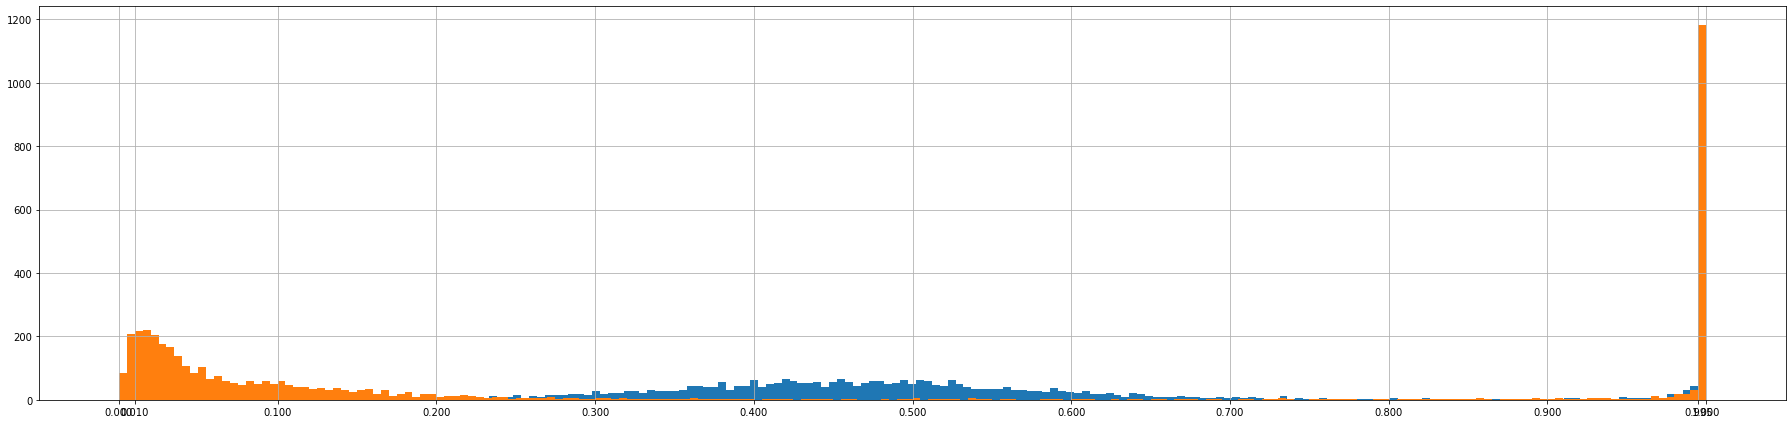

In [ ]:
plt.figure(figsize=(25,6))
plt.hist(y_pred.ravel(), bins=200)
plt.hist(y_pred_raw.ravel(), bins=200)
plt.xticks([0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.995, 1.0])
plt.grid("on")
plt.tight_layout()
plt.show()

Add data from raw file with prob < 0.01 and > 0.995.
